* Uplift Modeling is used to predict and target the right customers.
* It is a predictive modeling technique that directly models the incremental impact of a treatment (such as a direct marketing action) on an individual's behaviour.

In [ ]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_model = pd.read_csv('/content/data.csv')

In [ ]:
df_model.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
# check for missing values
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [ ]:
df_model.describe(include = np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [ ]:
# Checking unique object data
object_cols = [col for col in df_model.columns if df_model[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_model[obj].unique():
        print("{} {}".format(unique,sum(df_model[obj] == unique)))


 zip_code
Surburban 28776
Rural 9563
Urban 25661

 channel
Phone 28021
Web 28217
Multichannel 7762

 offer
Buy One Get One 21387
No Offer 21306
Discount 21307


# Data Preprocessing

In [ ]:
# Rename target column
df_model = df_model.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
df_model = df_model.rename(columns={'offer': 'treatment'})
df_model.treatment = df_model.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1})

In [ ]:
# One-Hot Encoding:
df_model = pd.get_dummies(df_model)

In [ ]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,-1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,-1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,-1,0,0,0,1,0,0,1


In [ ]:
# Split data with bogo and discount
df_model_bogo = df_model.copy().loc[df_model.treatment <=0].reset_index(drop=True)
df_model_discount = df_model.copy().loc[df_model.treatment >=0].reset_index(drop=True)

## Target Class Declaration
* Control Non-Responders (CN) - Customers that don't make a purchase without an offer (value = 0)
* Control Responders (CR) - Customers that make a purchase without an offer (value = 1)
* Treatment Non-Responders (TN) - Customers that don't make a purchase and receive an offer
* Treatment Responders (TR) - Customers that make a purchase and receive an offer (value = 3)

In [ ]:
# Function to declare Target Class
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 
    return df

In [ ]:
# run the functions for each treatment
df_model_bogo = declare_tc(df_model_bogo)
df_model_discount = declare_tc(df_model_discount)

## Uplift Score
Uplift Score = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

* where T denotes the total treated population (TR + TN)
* and C denotes the total untreated population CR+CN

In [ ]:
# Functions for Uplift
from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    """Train-Test Split
    """
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, \
    y_train, y_test  = train_test_split(X,
                                       y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test



In [ ]:
def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    """Using XGB to get the uplift score
    """
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()    
    # Fit the model
    uplift_model \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)

    # Predict using test-data
    uplift_proba \
    = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # Put the result 
    result['target_class'] = y_test
    return result


In [ ]:
def uplift(df_model:pd.DataFrame):
    """Combine the split and Modeling function
    """
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [ ]:
# Run the uplift function
bogo_uplift = uplift(df_model_bogo)
discount_uplift = uplift(df_model_discount)

In [ ]:
bogo_uplift.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
20765,10,211.48,1,0,0,0,0,1,0,1,0,0,0.451516,0.052382,0.451415,0.044688,-0.027751,1
7222,10,140.50,1,0,0,-1,0,0,1,0,1,0,0.474401,0.038627,0.448462,0.038510,0.007578,2
6434,4,76.25,1,0,0,-1,0,1,0,0,1,0,0.450209,0.051294,0.441745,0.056751,0.023128,2
32666,5,29.99,0,1,0,-1,1,0,0,0,1,0,0.442699,0.074099,0.383552,0.099649,0.125692,2
24212,9,248.28,1,0,0,-1,0,1,0,0,0,1,0.471690,0.073893,0.400803,0.053615,-0.034905,3


# Evaluation QINI Curve

The QINI uplift values can be calculated as QINI = (TR/T) - (CR/C).

In [ ]:
def qini_rank(uplift: pd.DataFrame):
  """Rank the data by the uplift score"""

  # Create new dataframe

  ranked = pd.DataFrame({'n' : [], 'target_class' : []})
  ranked['target_class'] = uplift['target_class']
  ranked['uplift_score'] = uplift['uplift_score']
  
  # Add proportion
  ranked['n'] = ranked.uplift_score.rank(pct = True, ascending = False)

  ranked = ranked.sort_values(by = 'n').reset_index(drop=True)
  return ranked

In [ ]:
def qini_eval(ranked: pd.DataFrame):
  """ Evaluate the uplift value with the QINI criterion"""
  uplift_model, random_model = ranked.copy(), ranked.copy()

  # using treatment and control group to calculate the uplift(incremental gain)

  C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class']>=2)
  ranked['cr'] = 0
  ranked['tr'] = 0
  ranked.loc[ranked.target_class == 1, 'cr'] = 1
  ranked.loc[ranked.target_class == 3, 'tr'] = 1
  ranked['cr/c'] = ranked.cr.cumsum()/C
  ranked['tr/t'] = ranked.tr.cumsum()/T

  # calculate and put the uplift and random value into dataframe

  uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'], 5)
  random_model['uplift'] = round(ranked['n']*uplift_model['uplift'].iloc[-1], 5)

  # Add q0
  q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
  uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
  random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
  # Add model name & concat
  uplift_model['model'] = 'Uplift model'
  random_model['model'] = 'Random model'
  merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
  return merged



In [ ]:
def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax

In [ ]:
def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

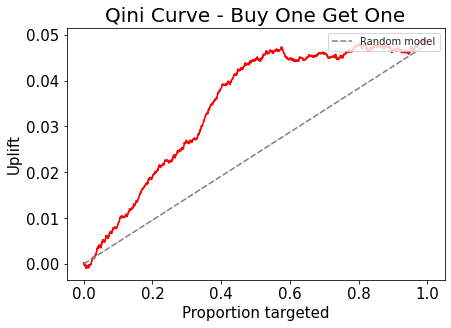

In [ ]:
# plot the Qini curve for BOGO treatment
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=20)

Text(0.5, 1.0, 'Qini Curve - Discount')

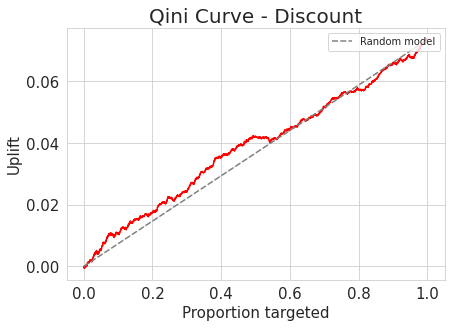

In [ ]:
# plot the Qini curve for Discount treatment
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)